In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-26 22:44:18.570977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 22:44:19.940795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-04-26 20:14:27.175627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [218]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId",
           "DMesons_fitOutput__ImpactSignificance"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [8]:
DMesons_df = generate_df(DMesonsTTree, branches, 2000000)
DMesons_df = apply_cuts(DMesons_df)

pd.set_option('display.max_rows', 10)
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411],"[[6.094892978668213, 1.3074619770050049, 2.733...","[(0.15998553, 0.011107716, -0.0614343)]","[(2.6128821, 2.7195172, 2.9228168)]","[(-321, 211, 211)]",[0.5543845891952515]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]","[[6.457057952880859, 5.970093250274658, 6.6375...","[(-1.608788, -1.6307458, -1.7315177), (-1.7326...","[(-0.371787, -0.5164238, -0.4971406), (-0.4966...","[(-321, 211, 211), (2212, -321, 211)]","[1.8095015287399292, 1.8095015287399292]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]","[[3.7944977283477783, 3.3083105087280273, 3.06...","[(-0.073717244, 0.22605924, -0.017923404), (0....","[(0.753864, 0.6827104, 0.920779), (0.6827104, ...","[(-321, 211, 211), (2212, -321, 211)]","[2.292919158935547, 2.292919158935547]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]","[[3.7815563678741455, 7.396467208862305, 1.412...","[(-0.9284433, -1.182188, -1.1012387), (-1.1821...","[(0.8518817, 0.7419038, 0.77916163), (0.741903...","[(-321, 211, 211), (2212, -321, 211)]","[0.7992758750915527, 0.7992758750915527]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122],"[[18.936317443847656, 15.39889907836914, 1.803...","[(0.69086045, 0.62282157, 0.63955635)]","[(0.857847, 0.81737196, 0.7582323)]","[(2212, -321, 211)]",[1.1388494968414307]
...,...,...,...,...,...,...,...,...,...,...,...
823353,[19.1050703125],[1.6708742380142212],[1802.5220947265625],[0.5411524176597595],[0.5503742098808289],[411],"[[12.198583602905273, 2.20495867729187, 4.7119...","[(1.705293, 1.5110217, 1.6457342)]","[(2.8939261, 2.7120652, 2.8616462)]","[(-321, 211, 211)]",[2.8667211532592773]
823354,"[35.5684921875, 35.5684921875]","[-1.688397765159607, -1.688397765159607]","[1844.779541015625, 2206.408203125]","[13.070379257202148, 13.070379257202148]","[-0.9140324592590332, -0.8278874754905701]","[411, 4122]","[[5.796909809112549, 20.56328582763672, 9.2475...","[(-1.6683935, -1.7061399, -1.6597538), (-1.706...","[(1.4682562, 1.4755678, 1.4053382), (1.4755678...","[(-321, 211, 211), (2212, -321, 211)]","[3.2546143531799316, 3.2546143531799316]"
823355,"[8.96414453125, 8.96414453125]","[-2.151238203048706, -2.151238203048706]","[1906.624267578125, 2233.773193359375]","[1.6992524862289429, 1.6992524862289429]","[0.1967991143465042, 0.495256245136261]","[411, 4122]","[[3.0222578048706055, 5.220008850097656, 0.736...","[(-2.0755956, -2.2418754, -1.6611706), (-2.241...","[(1.9180546, 1.8532572, 2.0587387), (1.8532572...","[(-321, 211, 211), (2212, -321, 211)]","[0.9604215025901794, 0.9604215025901794]"
823356,[17.66424609375],[-0.09207434207201004],[1886.3043212890625],[1.2944053411483765],[0.28153401613235474],[411],"[[9.11902904510498, 5.195584774017334, 3.37626...","[(-0.045325126, -0.065605104, -0.25413564)]","[(1.7839004, 1.9068127, 1.8262501)]","[(-321, 211, 211)]",[3.164067029953003]


In [220]:
Lambda_df = generate_df(LambdaMesonsTTree, branches, 2000000)
Lambda_df = apply_cuts(Lambda_df)

pd.set_option('display.max_rows', 10)
Lambda_df

In [ ]:
#DMesons_df = remove_duplicates(DMesons_df)
Lambda_df = remove_duplicates(Lambda_df)

Removed 0 duplicate particles


In [11]:
save(DMesons_df, "DMesons_df")
save(Lambda_df, "Lambda_df")

In [221]:
DMesons_df = load("DMesons_df")
Lambda_df = load("Lambda_df")

In [222]:
DMesons_df = DMesons_df.head(500000)
Lambda_df = Lambda_df.head(500000)

In [223]:
#separates each particle of the event into it's own event in a new data frame (for training)
def separate(df):
    dfs = []
    for index, row in df.iterrows():

        #reco Ds
        pts = row['DMesons_pt']
        etas = row['DMesons_eta']
        ms = row['DMesons_m']
        lxys = row['DMesons_fitOutput__Lxy']
        costhetastars = row['DMesons_costhetastar']
        impacts = row['DMesons_fitOutput__ImpactSignificance']
        pdgids = row["DMesons_pdgId"]

        #reco Ds Daughter info
        daughter_pts = row["DMesons_daughterInfo__pt"]
        daughter_etas = row["DMesons_daughterInfo__eta"]
        daughter_phis = row["DMesons_daughterInfo__phi"]
        daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]

        d = {df.columns[0]: pts, df.columns[1]: etas, df.columns[2]: ms, df.columns[3]: lxys, 
             df.columns[4]: costhetastars, df.columns[5]: pdgids, 

             df.columns[6]: daughter_pts, df.columns[7]: daughter_etas, df.columns[8]: daughter_phis, 
             df.columns[9]: daughter_pdgIds, 
             
             df.columns[10]: impacts}
        
        df = pd.DataFrame(data=d)

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop = True)
    return df

In [ ]:
#DMesons_df = separate(DMesons_df)
Lambda_df = separate(Lambda_df)

In [4]:
# save(DMesons_df, "DMesons_df_separated")
# save(Lambda_df, "Lambda_df_separated")

# DMesons_df = load("DMesons_df_separated")
# Lambda_df = load("Lambda_df_separated")

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")

len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [11]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(DMesons_df)

(6280052, 6017574)

In [55]:
def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

#new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [56]:
save(only_4122, "DMesons_only_4122")

In [ ]:
# create a new column 'particle_type' based on the pdgId column

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

Lambda_df['particle_type'] = Lambda_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = Lambda_df[Lambda_df['particle_type'] == 'only_411']
only_4122 = Lambda_df[Lambda_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

# new_df = Lambda_df[Lambda_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [ ]:
save(only_4122, "Lambda_only_4122")

In [231]:
# Read
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_4122 = load("Sherpa_DMesons_only_4122")

In [234]:
len(DMesons_only_4122)

690863

In [235]:
DMesons_only_4122['DMesons_pdgId'] = DMesons_only_4122['DMesons_pdgId'].replace({4122: 411})

DMesons_only_4122

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type
27,124.551781,0.616144,2252.343994,1.000073,0.309355,411,"[45.35352325439453, 55.5874137878418, 23.73572...","(0.62828386, 0.6060324, 0.61673385)","(3.135228, 3.1389863, -3.1324918)","(2212, -321, 211)",1.687575,only_4122
28,52.491680,0.628072,2420.752197,9.001939,-0.999371,411,"[45.325809478759766, 3.1020970344543457, 3.886...","(0.6306876, 0.61715966, 0.6021761)","(3.1351142, 3.1380522, -3.100118)","(2212, -321, 211)",4.709635,only_4122
29,51.824703,0.628606,2289.998535,0.752138,-0.955626,411,"[45.20779800415039, 5.494213104248047, 1.12326...","(0.6285973, 0.60806257, 0.7257996)","(3.135263, 3.1376371, 3.0532124)","(2212, -321, 211)",0.082626,only_4122
30,74.569516,0.623304,2320.748779,0.825154,-0.988731,411,"[45.4151725769043, 5.492096424102783, 23.73572...","(0.6285476, 0.6079869, 0.61673385)","(3.1352143, 3.1375391, -3.1324918)","(2212, -321, 211)",0.285478,only_4122
31,52.139363,0.628442,2114.455566,14.295114,-0.967880,411,"[45.4952392578125, 5.527915000915527, 1.113548...","(0.6305013, 0.60626864, 0.66872984)","(3.1350088, 3.1403995, -3.1118574)","(2212, -321, 211)",4.459208,only_4122
...,...,...,...,...,...,...,...,...,...,...,...,...
769898,15.015752,-1.621316,2128.959717,1.055468,-0.955383,411,"[10.978409767150879, 1.5513936281204224, 2.492...","(-1.6365633, -1.4952528, -1.6247052)","(-0.16868365, -0.11923864, -0.22785482)","(-2212, 321, -211)",4.102871,only_4122
769899,13.776949,-1.625336,2419.603516,0.624960,-0.933207,411,"[11.055854797363281, 1.5394558906555176, 1.245...","(-1.6374356, -1.5005118, -1.6150558)","(-0.1682525, -0.11801015, 0.16930138)","(-2212, 321, -211)",1.601410,only_4122
769900,16.353774,-1.603238,2288.062256,3.461010,-0.961579,411,"[11.229562759399414, 1.516668438911438, 3.6428...","(-1.6382093, -1.4983779, -1.5304362)","(-0.16720171, -0.11406519, -0.21755505)","(-2212, 321, -211)",2.295237,only_4122
769901,14.328731,-1.612592,2169.589355,1.799214,-0.948991,411,"[11.196073532104492, 1.5245026350021362, 1.622...","(-1.6378483, -1.4999491, -1.5262128)","(-0.16747509, -0.1153605, -0.27906275)","(-2212, 321, -211)",2.297870,only_4122


In [236]:
Lambda_only_4122 = Lambda_only_4122.head(500000)
DMesons_only_4122 = DMesons_only_4122.head(500000)
DMesons_only_4122 = DMesons_only_4122.reset_index(drop=True)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_4122], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

Text(0.5, 0, 'Candidate $\\Lambda_C^+$ Mass (MeV)')

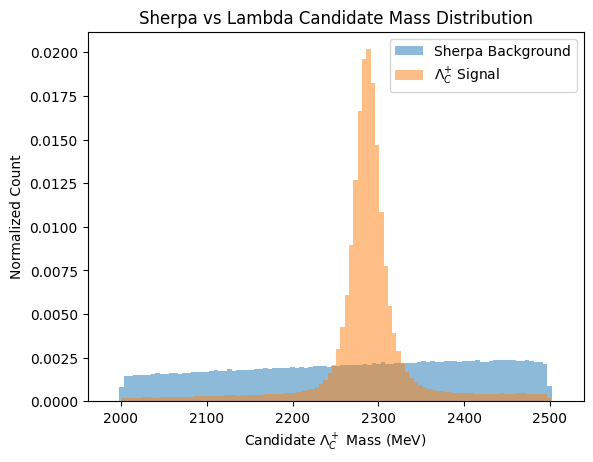

In [807]:
counts, bins, _ = plt.hist(DMesons_only_4122["DMesons_m"], bins=100)
counts2, bins2, _ = plt.hist(Lambda_only_4122["DMesons_m"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

    # Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs Lambda Candidate Mass Distribution")
plt.legend()
plt.ylabel("Normalized Count")
plt.xlabel("Candidate $\Lambda_C^+$ Mass (MeV)")

Text(0.5, 0, 'Candidate $\\Lambda_C^+$ Mass (MeV)')

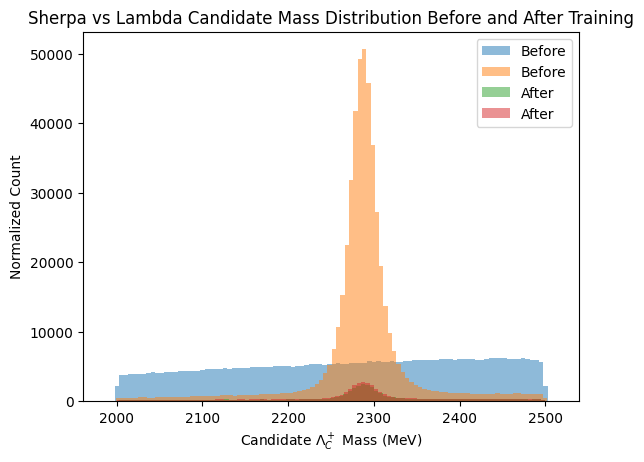

In [830]:
plt.hist(DMesons_only_4122["DMesons_m"], bins = 100, alpha = 0.5, label = "Before");
plt.hist(Lambda_only_4122["DMesons_m"], bins = 100, alpha = 0.5, label = "Before");
plt.hist(passed_Background_both["DMesons_m"], bins=100, alpha = 0.5, label = "After")
plt.hist(passed_Signal_both["DMesons_m"], bins=100, alpha = 0.5, label = "After");
plt.title("Sherpa vs Lambda Candidate Mass Distribution Before and After Training")
plt.legend()
plt.ylabel("Normalized Count")
plt.xlabel("Candidate $\Lambda_C^+$ Mass (MeV)")

In [238]:
shuffled_df['DMesons_daughterInfo__pdgId'] = [(2212, -321, 211)] * len(shuffled_df)

In [239]:
shuffled_df["DMesons_daughterInfo__eta"] = shuffled_df["DMesons_daughterInfo__eta"].apply(list)
shuffled_df["DMesons_daughterInfo__phi"] = shuffled_df["DMesons_daughterInfo__phi"].apply(list)

In [ ]:
#shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [240]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(eta)
        daughter_phis.append(phi)

In [241]:
#particle1 is proton, or pion in D+ hyp
#particle2 is kaon
#particle3 is pion

particle1_pt = []
particle2_pt = []
particle3_pt = []

particle1_eta = []
particle2_eta = []
particle3_eta = []

particle1_phi = []
particle2_phi = []
particle3_phi = []

for i in range(0, len(daughter_pts), 3):
    #daughter_pt
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])
    
    #daughter_eta
    particle1_eta.append(daughter_etas[i])
    particle2_eta.append(daughter_etas[i+1])
    particle3_eta.append(daughter_etas[i+2])
    
    #daughter_phi
    particle1_phi.append(daughter_phis[i])
    particle2_phi.append(daughter_phis[i+1])
    particle3_phi.append(daughter_phis[i+2])

In [ ]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton) (second pion was kaon)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi

In [ ]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411" or "only_4122":
                #D+ Hypothesis: assume proton is pion for 
                #Lambda Hypothesis: keep proton as proton
                return p_mass
            else:
                raise Exception("Are there more particle types?")
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = k_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [259]:
LorentzVectors = createTLorentzVectors(shuffled_df)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

(1000000, 3)

In [262]:
pk_list = []
kpi_list = []
ppi_list = []

#find the ordering of the Loretnz Vectors

#Lambda Hypothesis
p_LorentzVectors = []
k_LorentzVectors = []
pi_LorentzVectors = []
for i in LorentzVectors:
    if round(i.M(), 3) == p_mass:
        p_LorentzVectors.append(i)
    elif round(i.M(), 6) == k_mass:
        k_LorentzVectors.append(i)
    elif round(i.M(), 4) == 0.1396:
        pi_LorentzVectors.append(i)

#D+ Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for sublist in reshaped_list:
#     for i in range(len(sublist)):
#         if round(sublist[i].M(), 4) == 0.1396 and i == 0:
#             p_LorentzVectors.append(sublist[0])
#         elif round(sublist[i].M(), 4) == 0.4937 and i == 1:
#             k_LorentzVectors.append(sublist[1])
#         elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
#             pi_LorentzVectors.append(sublist[2])

In [263]:
for i in range(len(p_LorentzVectors)):
    pk = inv_mass_squared(p_LorentzVectors[i], k_LorentzVectors[i])
    kpi = inv_mass_squared(k_LorentzVectors[i], pi_LorentzVectors[i])
    ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
    pk_list.append(pk)
    kpi_list.append(kpi)
    ppi_list.append(ppi)

In [197]:
#Lambda
# for i in range(len(p_LorentzVectors)):
#     ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
#     ppi_list.append(ppi)

In [190]:
#D
# for i in range(len(p_LorentzVectors)):
#     pipi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
#     pipi_list.append(pipi)

In [264]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton) (second pion was kaon)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi

shuffled_df['inv_mass7'] = pk_list
shuffled_df['inv_mass8'] = kpi_list
shuffled_df['inv_mass9'] = ppi_list

In [265]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,...,particle_type,inv_mass1,inv_mass2,inv_mass3,inv_mass4,inv_mass5,inv_mass6,inv_mass7,inv_mass8,inv_mass9
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,"[11.170928001403809, 2.831317901611328, 0.6029...","[-0.4977727, -0.55253094, -0.31940895]","[0.45178226, 0.5159005, 0.88359225]","(2212, -321, 211)",...,only_4122,1.424463,0.732076,1.873404,0.343701,0.463657,1.873404,2.510926,0.732076,2.778089
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,"[3.040483236312866, 6.920453071594238, 0.66697...","[-1.2389119, -1.2671988, -0.891992]","[2.288972, 2.2705233, 2.100124]","(2212, -321, 211)",...,only_4122,0.437135,1.342377,0.476848,0.116725,1.101903,0.476848,3.291010,1.342377,1.481510
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,"[4.130668640136719, 2.183924913406372, 1.80589...","[0.61786264, 0.9393891, 0.7249763]","[-2.7951388, -3.0525513, -2.6634498]","(2212, -321, 211)",...,only_4122,2.183149,1.235540,0.304696,1.616657,0.851758,0.304696,3.605317,1.235540,1.562662
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,"[5.195446968078613, 7.804042816162109, 1.53329...","[1.7886169, 1.6211084, 1.7547115]","[-0.67071944, -0.5331284, -0.63166416]","(2212, -321, 211)",...,only_4122,2.384678,0.734953,0.133974,1.985845,0.460789,0.133974,4.349245,0.734953,1.240154
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,"[5.592108726501465, 0.7378090620040894, 2.8988...","[1.0165381, 0.6699291, 0.87115043]","[0.7204874, 0.5911911, 0.61206007]","(2212, -321, 211)",...,only_4122,3.025494,1.376170,0.623499,0.796600,0.217839,0.623499,3.987457,1.376170,1.883637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,"[19.53499984741211, 10.94820785522461, 1.82099...","[-0.059171885, -0.013583427, -0.018911816]","[-2.877898, -2.9645057, -2.8272035]","(2212, -321, 211)",...,only_4122,2.757283,0.796590,0.398840,2.132483,0.534964,0.398840,4.099238,0.796590,1.339467
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,"[10.073150634765625, 30.05179214477539, 8.9344...","[-1.5475895, -1.54694, -1.5712011]","[1.316317, 1.3007066, 1.3279157]","(2212, -321, 211)",...,only_4122,0.476911,0.758174,0.140392,0.177466,0.465773,0.140392,3.901641,0.758174,1.780263
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,"[12.885456085205078, 2.0564074516296387, 0.600...","[0.013616143, -0.08536845, -0.07438314]","[0.5507237, 0.59127384, 0.8937046]","(2212, -321, 211)",...,only_4122,2.070365,0.513330,1.412748,0.466976,0.222930,1.412748,3.072219,0.513330,2.314334
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,"[3.514936923980713, 5.062290668487549, 1.09335...","[0.21267407, 0.22728372, 0.44851756]","[-1.1488833, -1.3185775, -1.2333149]","(2212, -321, 211)",...,only_4122,0.974722,0.715890,0.345574,0.595541,0.439397,0.345574,3.062715,0.715890,1.491429


In [266]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
invmass_ready_df["daughter_pt1"] = particle1_pt
invmass_ready_df["daughter_pt2"] = particle2_pt
invmass_ready_df["daughter_pt3"] = particle3_pt
invmass_ready_df["daughter_eta1"] = particle1_eta
invmass_ready_df["daughter_eta2"] = particle2_eta
invmass_ready_df["daughter_eta3"] = particle3_eta
invmass_ready_df["daughter_phi1"] = particle1_phi
invmass_ready_df["daughter_phi2"] = particle2_phi
invmass_ready_df["daughter_phi3"] = particle3_phi
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,1.598548,1.424463,0.732076,1.873404,...,2.778089,11.170928,2.831318,0.602950,-0.497773,-0.552531,-0.319409,0.451782,0.515900,0.883592
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,2.001802,0.437135,1.342377,0.476848,...,1.481510,3.040483,6.920453,0.666974,-1.238912,-1.267199,-0.891992,2.288972,2.270523,2.100124
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,0.782303,2.183149,1.235540,0.304696,...,1.562662,4.130669,2.183925,1.805893,0.617863,0.939389,0.724976,-2.795139,-3.052551,-2.663450
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,1.275064,2.384678,0.734953,0.133974,...,1.240154,5.195447,7.804043,1.533298,1.788617,1.621108,1.754712,-0.670719,-0.533128,-0.631664
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,2.443815,3.025494,1.376170,0.623499,...,1.883637,5.592109,0.737809,2.898830,1.016538,0.669929,0.871150,0.720487,0.591191,0.612060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,2.293643,2.757283,0.796590,0.398840,...,1.339467,19.535000,10.948208,1.820998,-0.059172,-0.013583,-0.018912,-2.877898,-2.964506,-2.827204
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,0.641638,0.476911,0.758174,0.140392,...,1.780263,10.073151,30.051792,8.934455,-1.547590,-1.546940,-1.571201,1.316317,1.300707,1.327916
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,0.989076,2.070365,0.513330,1.412748,...,2.314334,12.885456,2.056407,0.600632,0.013616,-0.085368,-0.074383,0.550724,0.591274,0.893705
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,0.318123,0.974722,0.715890,0.345574,...,1.491429,3.514937,5.062291,1.093358,0.212674,0.227284,0.448518,-1.148883,-1.318578,-1.233315


In [28]:
#save(invmass_ready_df, "Sherpa_invmass_ready_df")
invmass_ready_df = load("Sherpa_invmass_ready_df")

In [29]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0 or x == 411:
        return 'only_411'
    elif x == 1 or x == 4122:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)
# only_411 = only_411.reset_index(drop=True)
# only_4122 = only_4122.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [30]:
only_411 = only_411.drop('particle_type', axis=1)
only_4122 = only_4122.drop('particle_type', axis=1)
new_df = new_df.drop("particle_type", axis=1)

# new_df = new_df.drop('DMesons_m', axis=1)
# only_411 = only_411.drop('DMesons_m', axis=1)
# only_4122 = only_4122.drop('DMesons_m', axis=1)

In [36]:
new_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,1.598548,1.424463,0.732076,1.873404,...,2.778089,11.170928,2.831318,0.602950,-0.497773,-0.552531,-0.319409,0.451782,0.515900,0.883592
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,2.001802,0.437135,1.342377,0.476848,...,1.481510,3.040483,6.920453,0.666974,-1.238912,-1.267199,-0.891992,2.288972,2.270523,2.100124
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,0.782303,2.183149,1.235540,0.304696,...,1.562662,4.130669,2.183925,1.805893,0.617863,0.939389,0.724976,-2.795139,-3.052551,-2.663450
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,1.275064,2.384678,0.734953,0.133974,...,1.240154,5.195447,7.804043,1.533298,1.788617,1.621108,1.754712,-0.670719,-0.533128,-0.631664
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,2.443815,3.025494,1.376170,0.623499,...,1.883637,5.592109,0.737809,2.898830,1.016538,0.669929,0.871150,0.720487,0.591191,0.612060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,2.293643,2.757283,0.796590,0.398840,...,1.339467,19.535000,10.948208,1.820998,-0.059172,-0.013583,-0.018912,-2.877898,-2.964506,-2.827204
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,0.641638,0.476911,0.758174,0.140392,...,1.780263,10.073151,30.051792,8.934455,-1.547590,-1.546940,-1.571201,1.316317,1.300707,1.327916
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,0.989076,2.070365,0.513330,1.412748,...,2.314334,12.885456,2.056407,0.600632,0.013616,-0.085368,-0.074383,0.550724,0.591274,0.893705
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,0.318123,0.974722,0.715890,0.345574,...,1.491429,3.514937,5.062291,1.093358,0.212674,0.227284,0.448518,-1.148883,-1.318578,-1.233315


In [311]:
save(new_df, "Sherpa_new_df_invmassdaughter_train")
save(only_411, "Sherpa_only_411_invmassdaughter_train")
save(only_4122, "Sherpa_only_4122_invmassdaughter_train")

In [15]:
new_df = load("Sherpa_new_df_invmassdaughter_train")
only_411 = load("Sherpa_only_411_invmassdaughter_train")
only_4122 = load("Sherpa_only_4122_invmassdaughter_train")

In [37]:
training_columns = get_columns(new_df)
training_columns.remove('DMesons_pdgId')

#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[training_columns], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[training_columns], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[training_columns], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [17]:
X_train2

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,inv_mass5,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
538586,12.705720,-0.698439,0.246635,0.511636,2.899194,1.007302,0.790970,0.239728,0.638040,0.435885,...,1.868737,3.516460,5.810607,3.406806,-0.777165,-0.668382,-0.661450,-2.098254,-1.974141,-2.107444
998317,8.973795,0.760623,0.171745,-0.167550,0.982162,1.635148,1.225122,1.377628,0.846223,0.951336,...,2.313232,6.128623,2.343093,0.619305,0.758523,0.806679,0.460297,-2.737804,-2.513898,3.090272
170259,27.252631,-1.008994,0.500032,0.466187,0.806648,0.732254,1.284142,0.297053,0.359140,0.932512,...,1.892628,8.235380,11.979066,7.051362,-0.988521,-1.033864,-0.987662,2.355257,2.382839,2.293891
521354,22.986543,0.661481,0.946673,-0.468670,0.700501,1.697978,1.391902,0.824505,0.902667,0.899833,...,2.088002,12.560632,4.905177,5.561325,0.635485,0.641961,0.732204,-2.257213,-2.142932,-2.291247
676166,21.414721,1.794634,0.401414,-0.935450,1.067238,3.143414,1.032644,0.171329,0.979283,0.322965,...,1.246973,15.517607,2.019337,3.895612,1.805994,1.677767,1.802546,2.688983,2.778923,2.660531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519031,20.802482,0.531966,0.107162,-0.643300,2.503792,2.200135,0.829913,1.464172,0.897314,0.551343,...,2.367851,16.634180,3.270125,0.909972,0.525678,0.625326,0.281214,-1.168467,-1.232027,-1.077075
731579,8.430931,0.095262,0.181114,-0.752748,1.864368,1.430448,1.394581,0.709885,0.567335,0.496565,...,2.462858,3.574376,1.134017,3.752527,0.011210,0.346748,0.096950,-3.130861,-3.101759,-2.931139
264024,11.675851,-0.240886,0.282393,0.393411,1.172477,0.940029,1.065742,0.126512,0.581303,0.669727,...,2.061706,2.973179,4.899405,3.844131,-0.241913,-0.281975,-0.185968,2.966856,-3.135537,2.998766
294064,8.894503,0.880072,0.548420,-0.832139,2.381865,1.804167,1.587702,0.551339,0.584398,0.752214,...,1.937587,4.982539,1.080452,2.908095,0.848048,0.862962,0.919132,-2.852720,-2.562182,-3.018109


In [507]:
# LorentzVectors_only_4122 = createTLorentzVectors(only_4122)
# reshaped_list_only_4122 = [LorentzVectors_only_4122[i:i+3] for i in range(0, len(LorentzVectors_only_4122), 3)]
# np.shape(reshaped_list_only_4122)

In [313]:
#(X_train1[column], X[train2], title, xlabel)

# data_list = [(X_train1["inv_mass1"], X_train2["inv_mass1"], "Histogram of $m^2(pK^{-} -> \pi^{+}K)$ ($D^{+}$ Hypothesis)", "$m^2(pK^{-}) [GeV^{2}]$"),
#              (X_train1["inv_mass2"], X_train2["inv_mass2"], "Histogram of $m^2(k^{-}\pi^{+})$ ($D^{+}$ Hypothesis)", "$m^2 k^{-}\pi [GeV]^2$"),
#              (X_train1["inv_mass3"], X_train2["inv_mass3"], "Histogram of $m^2(p\pi^{+})$ ($D^{+}$ Hypothesis)", "$m^2(pK^{-}) [GeV^{2}]$"),
#              (X_train1["inv_mass7"], X_train2["inv_mass7"], "Histogram of $m^2(pK^{-})$ ($\Lambda_C{+}$ Hypothesis) 7", "$m^2(pK^{-}) [GeV^{2}]$"),
#              (X_train1["inv_mass9"], X_train2["inv_mass9"], "Histogram of $m^2(p\pi^{+})$) 9", "$m^2(p\pi^{+}) [GeV^{2}]$"),
#              (X_train1["inv_mass4"], X_train2["inv_mass4"], "Histogram of $m^2(k^{-}\pi^{+})$ ($\Lambda_C^{+}$ Hypothesis)", "$m^2 k^{-}\pi [GeV]^2$"),
#              (X_train1["DMesons_pt"], X_train2["DMesons_pt"], "Signal vs Backround P_t (Normalized)", "Transverse Momentum (p_t) [GeV]"),
#              (X_train1["DMesons_fitOutput__Lxy"], X_train2["DMesons_fitOutput__Lxy"], "Signal vs Backround $L_{xy}$ (Normalized)", "Decay Length (L_xy) [mm]"),
#              (X_train1["DMesons_costhetastar"], X_train2["DMesons_costhetastar"], "Signal vs Backround cosθ* (Normalized)", "Cosine of Helicity Angle (cosθ*)"),
#              (X_train1["DMesons_fitOutput__ImpactSignificance"], X_train2["DMesons_fitOutput__ImpactSignificance"], "Signal vs Backround DMesons ImpactSignificance (Normalized)", "DMesons_fitOutput__ImpactSignificance")
#             ]

# def plot_normalized_histograms(data_list, bins):
#     for data1, data2, title, xlabel in data_list:
#         hist_normalized(data1, data2, bins)
#         plt.title(title)
#         plt.xlabel(xlabel)
#         plt.ylabel("Normalized Counts")
#         plt.legend()
#         plt.show()

# plot_normalized_histograms(data_list, 100)

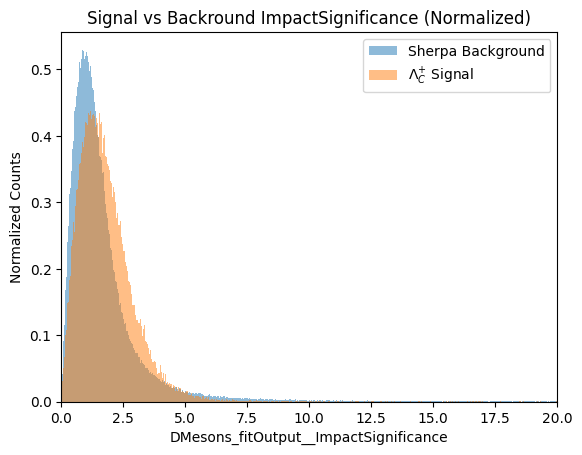

In [405]:
counts, bins, _ = plt.hist(X_train1["DMesons_fitOutput__ImpactSignificance"], bins=10000)
counts2, bins2, _ = plt.hist(X_train2["DMesons_fitOutput__ImpactSignificance"], bins=10000)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Signal vs Backround ImpactSignificance (Normalized)")
plt.xlabel("DMesons_fitOutput__ImpactSignificance")
plt.xlim(0, 20)
plt.ylabel("Normalized Counts")
plt.legend()
plt.show()

In [18]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 256,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 128,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 50,
        "batch_size": 32
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh (atlasdnn). Use `wandb login --relogin` to force relogin


In [19]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6144      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  32896     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
Total params: 39,169
Trainable params: 39,169
Non-trainable params: 0
_________________________________________________________________


2023-04-30 14:29:22.453265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [20]:
#Compile
start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
#Train
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
24999/25000 [============================>.] - ETA: 0s - loss: 0.5583 - custom_accuracy: 0.7166

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.5583 - custom_accuracy: 0.7166 - val_loss: 0.4918 - val_custom_accuracy: 0.7680
Epoch 2/50
24993/25000 [============================>.] - ETA: 0s - loss: 0.4988 - custom_accuracy: 0.7619

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 47s 2ms/step - loss: 0.4988 - custom_accuracy: 0.7619 - val_loss: 0.4404 - val_custom_accuracy: 0.8038
Epoch 3/50
24975/25000 [============================>.] - ETA: 0s - loss: 0.4720 - custom_accuracy: 0.7793

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4719 - custom_accuracy: 0.7793 - val_loss: 0.4213 - val_custom_accuracy: 0.8123
Epoch 4/50
24980/25000 [============================>.] - ETA: 0s - loss: 0.4582 - custom_accuracy: 0.7879

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4583 - custom_accuracy: 0.7879 - val_loss: 0.4165 - val_custom_accuracy: 0.8155
Epoch 5/50
24997/25000 [============================>.] - ETA: 0s - loss: 0.4483 - custom_accuracy: 0.7929

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 47s 2ms/step - loss: 0.4483 - custom_accuracy: 0.7929 - val_loss: 0.3991 - val_custom_accuracy: 0.8236
Epoch 6/50
25000/25000 [==============================] - ETA: 0s - loss: 0.4394 - custom_accuracy: 0.7984

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4394 - custom_accuracy: 0.7984 - val_loss: 0.3975 - val_custom_accuracy: 0.8256
Epoch 7/50
24974/25000 [============================>.] - ETA: 0s - loss: 0.4317 - custom_accuracy: 0.8028

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 47s 2ms/step - loss: 0.4317 - custom_accuracy: 0.8028 - val_loss: 0.3918 - val_custom_accuracy: 0.8266
Epoch 8/50
24983/25000 [============================>.] - ETA: 0s - loss: 0.4244 - custom_accuracy: 0.8070

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 47s 2ms/step - loss: 0.4244 - custom_accuracy: 0.8070 - val_loss: 0.3757 - val_custom_accuracy: 0.8382
Epoch 9/50
25000/25000 [==============================] - 46s 2ms/step - loss: 0.4195 - custom_accuracy: 0.8099 - val_loss: 0.3849 - val_custom_accuracy: 0.8302
Epoch 10/50
25000/25000 [==============================] - ETA: 0s - loss: 0.4138 - custom_accuracy: 0.8138

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 47s 2ms/step - loss: 0.4138 - custom_accuracy: 0.8138 - val_loss: 0.3585 - val_custom_accuracy: 0.8421
Epoch 11/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.4099 - custom_accuracy: 0.8163 - val_loss: 0.3627 - val_custom_accuracy: 0.8440
Epoch 12/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.4070 - custom_accuracy: 0.8179 - val_loss: 0.3638 - val_custom_accuracy: 0.8437
Epoch 13/50
25000/25000 [==============================] - 48s 2ms/step - loss: 0.4050 - custom_accuracy: 0.8193 - val_loss: 0.3603 - val_custom_accuracy: 0.8468
Epoch 14/50
24999/25000 [============================>.] - ETA: 0s - loss: 0.4007 - custom_accuracy: 0.8213

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4007 - custom_accuracy: 0.8213 - val_loss: 0.3546 - val_custom_accuracy: 0.8468
Epoch 15/50
24985/25000 [============================>.] - ETA: 0s - loss: 0.3990 - custom_accuracy: 0.8229

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.3990 - custom_accuracy: 0.8229 - val_loss: 0.3491 - val_custom_accuracy: 0.8482
Epoch 16/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3968 - custom_accuracy: 0.8237 - val_loss: 0.3541 - val_custom_accuracy: 0.8472
Epoch 17/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3941 - custom_accuracy: 0.8259 - val_loss: 0.3530 - val_custom_accuracy: 0.8448
Epoch 18/50
24991/25000 [============================>.] - ETA: 0s - loss: 0.3936 - custom_accuracy: 0.8262

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.3935 - custom_accuracy: 0.8262 - val_loss: 0.3425 - val_custom_accuracy: 0.8521
Epoch 19/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3896 - custom_accuracy: 0.8279 - val_loss: 0.3466 - val_custom_accuracy: 0.8508
Epoch 20/50
24981/25000 [============================>.] - ETA: 0s - loss: 0.3889 - custom_accuracy: 0.8288

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_142915-1bwe8s78/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 47s 2ms/step - loss: 0.3889 - custom_accuracy: 0.8288 - val_loss: 0.3382 - val_custom_accuracy: 0.8560
Epoch 21/50
25000/25000 [==============================] - 48s 2ms/step - loss: 0.3870 - custom_accuracy: 0.8302 - val_loss: 0.3467 - val_custom_accuracy: 0.8487
Epoch 22/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3854 - custom_accuracy: 0.8311 - val_loss: 0.3453 - val_custom_accuracy: 0.8539
Epoch 23/50
 1271/25000 [>.............................] - ETA: 38s - loss: 0.3791 - custom_accuracy: 0.8328

KeyboardInterrupt: 

2023-04-30 14:30:11.026952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-04-30 14:30:11.039650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-30 14:30:11.189863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-04-30 14:30

In [21]:
wandb.finish()

custom_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇███████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_custom_accuracy,▁▄▅▅▅▆▆▇▆▇▇▇▇▇▇▇▇███▇█
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁
best_epoch,19
best_val_loss,0.33824
custom_accuracy,0.83106
epoch,21
loss,0.3854
val_custom_accuracy,0.8539


------------------------------------------ Finished training, now analyze ------------------------------------------

In [23]:
# # Plot the training and validation loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

In [444]:
#bulk
predictions_both = model.predict(X_test)
predictions_background = model.predict(X_test1)
predictions_signal = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [457]:
#daughter
predictions_both1 = model.predict(X_test)
predictions_background1 = model.predict(X_test1)
predictions_signal1 = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [ ]:
#daughter + dalitz
predictions_both2 = model.predict(X_test)
predictions_background2 = model.predict(X_test1)
predictions_signal2 = model.predict(X_test2)

3125/3125 [==============================] - 3s 960us/step


In [75]:
#get the index of the events that pass a cutoff of some value
passed_background_indicies = []
passed_signal_indicies = []

for i in range(len(predictions_background2)):
    # if predictions_background2[i] > 0.6:
    #     passed_background_indicies.append(i)
    if predictions_signal2[i] > -1:
        passed_signal_indicies.append(i)
    if predictions_background2[i] > -1:
        passed_background_indicies.append(i)

In [76]:
len(predictions_background2)

100000

In [77]:
len(passed_background_indicies)

100000

In [78]:
len(passed_signal_indicies)

100000

In [74]:
# passed_Background_df = X_train1.iloc[passed_background_indicies]
# passed_Background_df

# passed_Signal_df = X_train2.iloc[passed_signal_indicies]
# passed_Signal_df

passed_Background_both = X_train1.iloc[passed_background_indicies]
passed_Signal_both = X_train2.iloc[passed_signal_indicies]
passed_Background_both

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
767978,37.073844,1.462752,2003.260620,0.157061,0.009325,2.823630,1.071796,0.598454,0.441948,0.531299,...,2.014354,14.856505,10.171244,12.055143,1.444681,1.483535,1.466891,-2.684603,-2.723014,-2.723790
361836,10.994714,0.150317,2102.945312,0.089660,-0.871102,0.663922,1.613345,0.628513,1.292723,0.303510,...,2.274292,8.180739,1.664952,1.157125,0.192285,0.147180,-0.145103,-1.326465,-1.426655,-1.377755
685901,12.389280,-0.907366,2037.899414,0.144091,0.028923,2.514786,1.408765,0.636816,0.741263,0.804952,...,1.881383,6.756925,3.789603,1.876999,-0.849769,-0.920184,-1.064120,1.886834,2.039348,1.950387
881778,9.054401,-0.622994,2309.879883,0.164933,-0.641243,0.621863,1.506138,1.298000,0.427160,0.800405,...,2.411610,3.210924,1.576230,4.334403,-0.657752,-0.521886,-0.624580,-0.680463,-1.031237,-0.835155
164295,10.931538,0.255186,2405.515381,0.055915,-0.333474,0.815412,2.694632,1.074645,0.482902,2.073260,...,1.815951,5.043758,3.018271,2.922307,0.374781,0.086940,0.210651,-0.110363,-0.328059,-0.110053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87347,104.785445,0.799666,2017.571167,1.022089,0.452209,3.114371,1.011490,0.779408,1.069615,0.423635,...,2.007761,61.224552,37.886570,5.698136,0.803967,0.798746,0.759315,-2.849835,-2.838891,-2.831466
968402,15.571255,0.376038,2022.555298,0.205817,0.383917,0.935325,0.902506,0.780648,0.131917,0.499133,...,1.623699,5.229413,6.573122,3.791449,0.369910,0.355043,0.419740,-1.383385,-1.273765,-1.371169
934274,11.102452,-0.475571,2381.051270,0.033704,-0.864581,2.744966,2.705295,1.555884,0.183215,1.285320,...,1.531154,6.257930,1.235929,3.667179,-0.520266,-0.285801,-0.454619,3.032116,2.728363,3.032244
293228,10.994396,-0.128566,2197.863037,0.148978,-0.799343,2.174995,1.432038,1.577474,0.212498,0.471616,...,1.839002,5.036113,1.439768,4.546061,-0.127934,-0.298587,-0.073347,2.051070,2.194825,1.997325


In [79]:
passed_Background_both1 = X_train1.iloc[passed_background_indicies]
passed_Signal_both1 = X_train2.iloc[passed_signal_indicies]

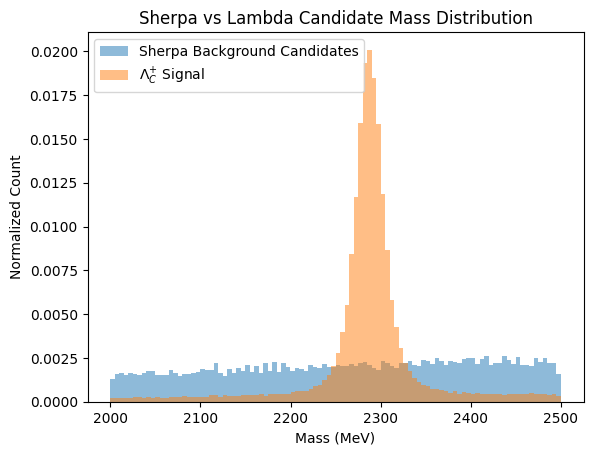

In [71]:
counts, bins, _ = plt.hist(passed_Background_both["DMesons_m"], bins=100)
counts2, bins2, _ = plt.hist(passed_Signal_both["DMesons_m"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

    # Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background Candidates")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs Lambda Candidate Mass Distribution")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

In [ ]:
counts, bins, _ = plt.hist(passed_Background_both["DMesons_m"], bins=100)
counts2, bins2, _ = plt.hist(passed_Signal_both["DMesons_m"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

    # Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background Candidates")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs Lambda Candidate Mass Distribution")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

In [44]:
#predict accuract given y_test and predictions from model
def pred_accuracy(y_test, predictions):
    D_count, Lambda_count = 0, 0

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            Lambda_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            D_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_both = pred_accuracy(y_test, list(predictions_both2))
accuracy_background = pred_accuracy(y_test1, list(predictions_background2))
accuracy_signal = pred_accuracy(y_test2, list(predictions_signal2))

print("Accuracy for Both: {:.2%}".format(accuracy_both))
print("Accuracy for Only Background: {:.2%}".format(accuracy_background))
print("Accuracy for Only Signal: {:.2%}".format(accuracy_signal))

Accuracy for Both: 85.62%
Accuracy for Only Background: 79.35%
Accuracy for Only Signal: 91.66%


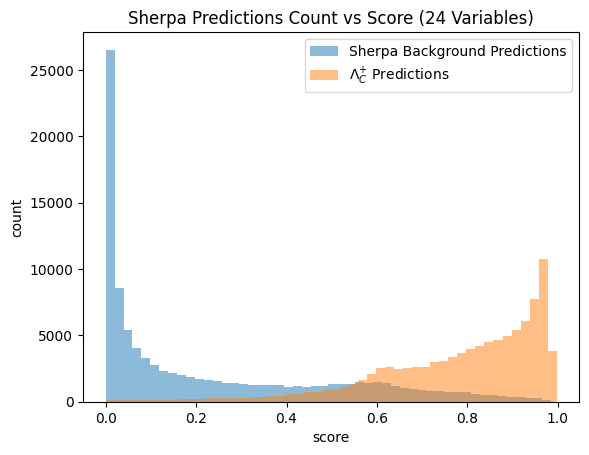

In [45]:
hist = plt.hist(predictions_background2, bins = 50, label = "Sherpa Background Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal2, bins = 50, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Sherpa Predictions Count vs Score ({} Variables)".format(len(training_columns)))
plt.legend()
plt.show()

In [448]:
#bulk
y_true = list(y_test)
y_pred = predictions_both

In [496]:
#daughter
y_true1 = list(y_test)
y_pred1 = predictions_both1

In [497]:
#daughter + dalitz
y_true2 = list(y_test)
y_pred2 = predictions_both2

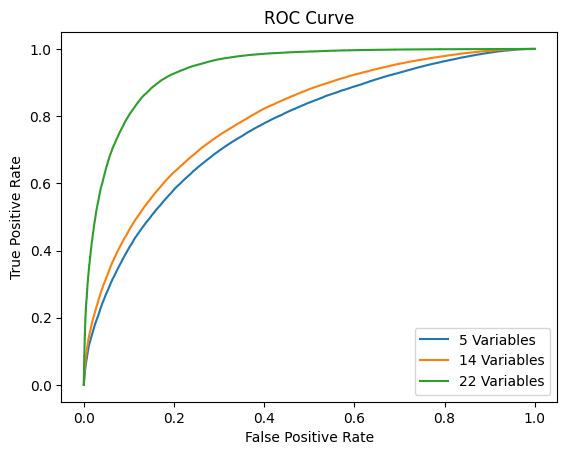

In [499]:
# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_pred1) 
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_pred2) 

# Plot ROC curve
plt.plot(fpr, tpr, label = "5 Variables")
plt.plot(fpr1, tpr1, label = "14 Variables")
plt.plot(fpr2, tpr2, label = "22 Variables")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()